# Preprocess

## Init

### Imports

In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import random
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from hd_utils import monitor
from string import ascii_lowercase
from sklearn.datasets.lfw import Bunch
from more_itertools import unique_everseen, take
from langdetect import detect as detect_lang, detect_langs

### Plot

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

### Args

In [4]:
args = Bunch()

## Read

In [5]:
_data_base_path = '../code-docstring-corpus/V2/parallel'
args.toplevelfuncs_desc_path = os.path.join(_data_base_path, 'parallel_desc')
args.methods_desc_path = os.path.join(_data_base_path, 'parallel_methods_desc')
args.desc_paths = [args.toplevelfuncs_desc_path, args.methods_desc_path]
args.max_descs = 1000000

In [6]:
def read_desc_gen(file_path):
    with open(file_path, 'r', errors='ignore') as f:
        for line in f:
            yield line.strip()[1:-1]
            
            
def read_all():
    all_gen = (read_desc_gen(desc_path) for desc_path in args.desc_paths)
    return list(take(args.max_descs, unique_everseen(chain.from_iterable(all_gen))))

In [7]:
%time descs = read_all()
len(descs)

CPU times: user 752 ms, sys: 212 ms, total: 964 ms
Wall time: 1.07 s


357220

## Filtering

In [8]:
args.len_lb, args.len_up = 25, 200
args.log_step = 5000
args.chars_threshold = 0.8

In [9]:
def is_english_detect(text):
    try:
        return detect_lang(text) == 'en'
    except:
        return False


def is_chinise(text):
    for c in text:
        if 0x4e00 <= ord(c) <= 0x9fff:
            return True
    return False


def is_ascii(text):
    return all(31 < ord(c) < 128 for c in text)

    
def is_plausible_chars(text):
    m = sum(bool(c in ascii_lowercase) for c in text.lower()) 
    n = len(text)
    return m / n >= args.chars_threshold and is_ascii(text)


def is_sensible(text):
    return is_english_detect(text) and is_plausible_chars(text)


def is_valid(desc):
    return args.len_lb <= len(desc) <= args.len_up and is_sensible(desc)

In [10]:
@monitor('[1.1.1] Preprocessing english sorting', log_step=args.log_step, log_total=len(descs))
def english_sorting(descs, *, log):
    new_descs = []
    for i, desc in enumerate(tqdm(descs)):
        if is_valid(desc):
            new_descs.append(desc)
        log.imetric(i, 'current len', len(new_descs))
    return new_descs

In [11]:
descs = english_sorting(descs)
len(descs)

100%|██████████| 357220/357220 [36:05<00:00, 164.95it/s]


149507

In [12]:
df = pd.DataFrame(descs, columns=['text'])
df.head()

,text
0,Find globals in this statement.
1,Returns True if the input phrase has a negativ...
2,Returns True if the input phrase has a positiv...
3,Returns: DCNL A speaker implementation availab...
4,Gets the keyword phrases from the keywords fil...


## Analysis

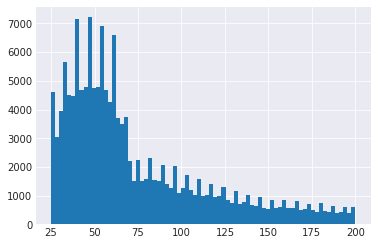

In [13]:
df.text.map(len).hist(bins=75);

In [14]:
df.text.sample(10).tolist()

['Mushroom collisions along the x axis',
 'Test load local infile with a valid file',
 'L{DigestCredentialFactory.decode} raises L{LoginFailed} when the given DCNL nonce from the response does not match the nonce encoded in the opaque.',
 'Calculate the frequency response of a discrete-time system. DCNL Returns a 2-tuple containing arrays of frequencies [rad/s] and DCNL complex magnitude. DCNL See `dfreqresp` for details.',
 'Guess mime type for a file in local filesystem. DCNL Return string containing valid mime type.',
 'Run the foreman on the client.',
 "Monitor system average load each \\'interval\\' seconds and recording DCNL process/threads info if system loadavg great than \\'load_threshold\\'.",
 'Return the address which this transport is pretending to be bound DCNL to.',
 'common code for quickly building an ansible module in Python DCNL (although you can write modules in anything that can return JSON) DCNL see library/* for examples',
 'Get the stylesheet from the visitor. D

## Save

In [15]:
args.save_path = 'docstring_data_text.hdf5'

In [16]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 116 ms, sys: 44 ms, total: 160 ms
Wall time: 169 ms


In [17]:
!du -sh $args.save_path

12M	docstring_data_text.hdf5


## End

In [18]:
args

{'chars_threshold': 0.8,
 'desc_paths': ['../code-docstring-corpus/V2/parallel/parallel_desc',
  '../code-docstring-corpus/V2/parallel/parallel_methods_desc'],
 'len_lb': 25,
 'len_up': 200,
 'log_step': 5000,
 'max_descs': 1000000,
 'methods_desc_path': '../code-docstring-corpus/V2/parallel/parallel_methods_desc',
 'save_path': 'docstring_data_text.hdf5',
 'toplevelfuncs_desc_path': '../code-docstring-corpus/V2/parallel/parallel_desc'}